# Disclaimer

This repository is NOT a simulator and will never be. It is a collision avoidance library that takes ship's states as input and outputs a safe trajectory.

# Instantiate Target Ships

In [8]:
from colav.obstacles import MovingShip
import numpy as np

# From Course & Speed Over Ground (CSOG)
ts1 = MovingShip.from_csog(
    position=(-60, 120),    # (x, y) [m]
    psi=170,                # Heading
    cog=165,                # Course over ground
    sog=3,                  # Speed over ground [m/s]
    loa=20,                 # length overall [m]
    beam=6,                 # [m]
    degrees=True,           # Whether psi and cog are provided in degrees (True) or radians (False)
    mmsi=None               # Maritime Mobile Service Identity
)

# From surge & sway speed
ts2 = MovingShip.from_body(
    position=(20, -100),    # (x, y) [m]
    psi=np.pi/8,            # Heading
    u=8,                    # Surge speed [m/s]
    v=0,                    # Sway speed [m/s]
    loa=40,                 # Length overall [m]
    beam=16,                # [m]
    degrees=False,          # Whether psi and cog are provided in degrees (True) or radians (False)
    mmsi=265041000          # Maritime Mobile Service Identity (Aurora AF Helsingborg ferry)
)

print(
    "mmsi of target ship 1 (fake): ", ts1.mmsi,
    "\nmmsi of target ship 2 (real): ", ts2.mmsi)   # Fake MMSI are negative by convention

mmsi of target ship 1 (fake):  -265224240 
mmsi of target ship 2 (real):  265041000


# Add Static Obstacles

In [9]:
from shapely import Polygon, Point

# Construct fake obstacles as shore: use .buffer to add safety margin.
shore = [
    Polygon([(0, 0), (30, 0), (30, 30), (0, 30), (0, 0)]), # Square obstacle
    Point(-50, -50).buffer(20) # Circle obstacle
]

# Add Safety Distance

In [10]:
safety_distance = 10 # Minimal distance w.r.t ship [m] -> very small here, should be at least > length overall

ts1_with_sd = ts1.buffer(safety_distance)   # Add safety margin using Minkowski sum
ts2_with_sd = ts2.buffer(safety_distance)   # Add safety margin using Minkowski sum
shore_with_sd = [obs.buffer(safety_distance) for obs in shore] # Add safety margin to the shore using Minkowski sum

# Display Target Ships (matplotlib)

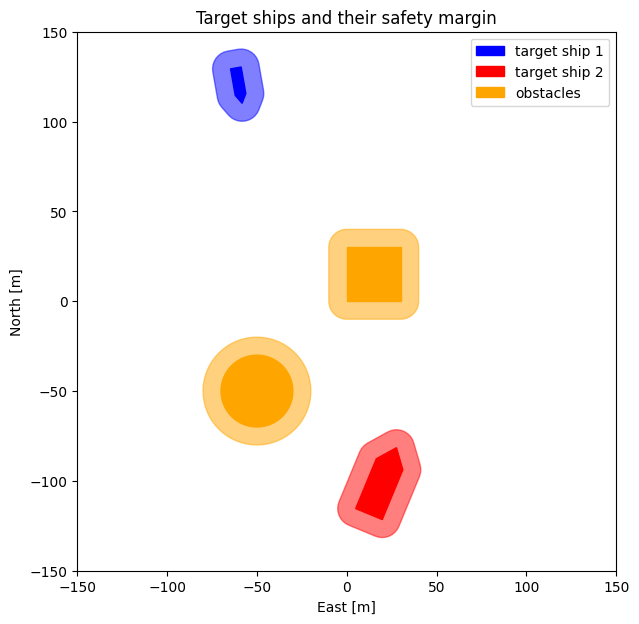

In [ ]:
import matplotlib.pyplot as plt

p0 = (100, -40) # Own ship position
pf = (-100, 30) # Target position

_, ax = plt.subplots(figsize=(7, 7))
ts1.fill(ax=ax, c='blue', label='target ship 1')
ts2.fill(ax=ax, c='red', label='target ship 2')
ts1_with_sd.fill(ax=ax, c='blue', alpha=0.5)
ts2_with_sd.fill(ax=ax, c='red', alpha=0.5)

for j, obs in enumerate(shore):
    ax.fill(*obs.exterior.xy, c='orange', label="obstacles" if j==0 else None)
    ax.fill(*shore_with_sd[j].exterior.xy, c='orange', alpha=0.5)

# Start and target position (Own ship)
ax.scatter(*p0, c='green', label='p0 (own ship)')
ax.scatter(*pf, c='purple', label='pf (own ship)')

ax.set_title(f"Target ships and their safety margin")
ax.set_xlim((-150, 150))
ax.set_ylim((-150, 150))
ax.set_xlabel("East [m]")
ax.set_ylabel("North [m]")
ax.set_aspect('equal')
ax.legend()
plt.show()
plt.close()

# Time-Space Projection

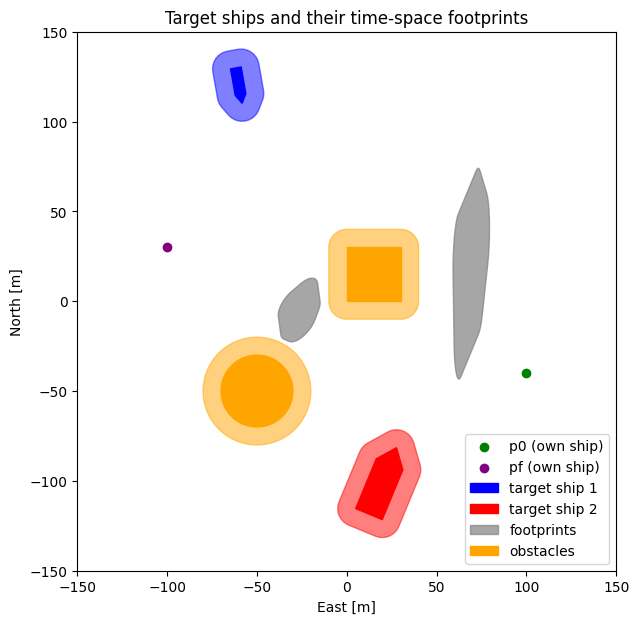

In [ ]:
from colav.timespace import TimeSpaceProjector
from typing import List

Vdes = 3 # Desired speed [m/s]

# Instantiate projector object
proj = TimeSpaceProjector(Vdes)

# Project target ships: Result is a list of shapely.Polygon object (https://shapely.readthedocs.io/en/stable/reference/shapely.Polygon.html)
projected_ships: List[Polygon] = proj.get(p0, pf, [ts1_with_sd, ts2_with_sd])

# Display target ships with their projected footprint
_, ax = plt.subplots(figsize=(7, 7))

# Start and target position (Own ship)
ax.scatter(*p0, c='green', label='p0 (own ship)')
ax.scatter(*pf, c='purple', label='pf (own ship)')

# Target ships
ts1.fill(ax=ax, c='blue', label='target ship 1')
ts2.fill(ax=ax, c='red', label='target ship 2')
ts1_with_sd.fill(ax=ax, c='blue', alpha=0.5)
ts2_with_sd.fill(ax=ax, c='red', alpha=0.5)

# Projected footprint
for i, projected_ship in enumerate(projected_ships):
    ax.fill(*projected_ship.exterior.xy, c='grey', alpha=0.7, label=f"footprints" if i==0 else None)

for j, obs in enumerate(shore):
    ax.fill(*obs.exterior.xy, c='orange', label="obstacles" if j==0 else None)
    ax.fill(*shore_with_sd[j].exterior.xy, c='orange', alpha=0.5)

ax.set_xlim((-150, 150))
ax.set_ylim((-150, 150))
ax.set_xlabel("East [m]")
ax.set_ylabel("North [m]")
ax.set_title(f"Target ships and their time-space footprints")
ax.set_aspect('equal')
ax.legend()
plt.show()
plt.close()

# Visibility Graph & Dijkstra

In [13]:
from colav.planner import TimeSpaceColav

planner = TimeSpaceColav(
    desired_speed=Vdes,         # Desired speed
    distance_threshold=1000,    # Minimal distance to include target ships in trajectory planning
    shore=shore_with_sd         # All the static obstacles with safety margin
)

traj = planner.get(
    p0=p0,                                  # Inital position of own ship
    pf=pf,                                  # Target position of own ship 
    obstacles=[ts1_with_sd, ts2_with_sd]    # Moving obstacles
)                                           # Returns a trajectory to go from p0 to pf while avoiding shore+obstacles

print(
    "Setpoints to avoid obstacles: \n",
    "\t- Desired speed [m/s]: ", traj.get_speed(0),                     # Desired speed to be forwarded to speed controller
    "\n\t- Desired heading [°]: ", traj.get_heading(0, degrees=True)    # Desired heading to be forwarded to heading controller
)

Setpoints to avoid obstacles: 
 	- Desired speed [m/s]:  3.2899086024096906 
	- Desired heading [°]:  -94.94357223244474


# Display trajectory

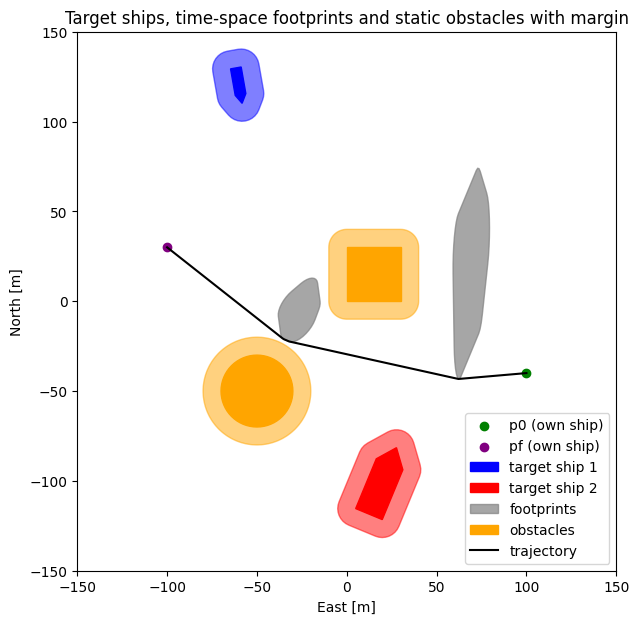

In [14]:
# Display target ships with their projected footprint
_, ax = plt.subplots(figsize=(7, 7))

# Start and target position (Own ship)
ax.scatter(*p0, c='green', label='p0 (own ship)')
ax.scatter(*pf, c='purple', label='pf (own ship)')

# Target ships
ts1.fill(ax=ax, c='blue', label='target ship 1')
ts2.fill(ax=ax, c='red', label='target ship 2')
ts1_with_sd.fill(ax=ax, c='blue', alpha=0.5)
ts2_with_sd.fill(ax=ax, c='red', alpha=0.5)

# Projected footprint
for i, projected_ship in enumerate(projected_ships):
    ax.fill(*projected_ship.exterior.xy, c='grey', alpha=0.7, label=f"footprints" if i==0 else None)

for j, obs in enumerate(shore):
    ax.fill(*obs.exterior.xy, c='orange', label="obstacles" if j==0 else None)
    ax.fill(*shore_with_sd[j].exterior.xy, c='orange', alpha=0.5)

if traj is not None:
    traj.plot(ax=ax, c='black', label="trajectory")

ax.set_xlim((-150, 150))
ax.set_ylim((-150, 150))
ax.set_xlabel("East [m]")
ax.set_ylabel("North [m]")
ax.set_title(f"Target ships, time-space footprints and static obstacles with margin")
ax.set_aspect('equal')
ax.legend()
plt.show()

# TODO
### Speed limits
### Yaw rate limits
### COLREGs
### Uncertainties
### Arbitrary trajectory